In [19]:
import pandas as pd
cols = pd.read_csv("../var_names.csv")
data = pd.read_csv('../CSCS_data_anon.csv', low_memory=False,
                        na_values=["9999", "", " ", "Presented but no response", "NA"])
empty = (data.isna().sum()==data.shape[0])
data = data[empty.index[~empty]] # keep non empty columns only
data = data[data.REMOVE_case=='No'].copy()

In [20]:
def get_matching_keywords(keywords: list[str], group_restriction: list[str]=None, year_restriction: list[int]=None, strict: bool=False) -> list[str]:
    """
    Returns the names of the columns whose string contains any of the keywords
    Can restrict to specific years by passing a list of years to year restriction
    Same for group restriction
    Strict means that a variable must be found in all years and all groups listed, non strict means it only needs to satisfy one year or one group
    """
    global data
    assert group_restriction == None or all({res.lower() in [None, "cohort", "cross"] for res in group_restriction})
    assert year_restriction == None or all({str(res) in [None, "2021", "2022", "2023"] for res in year_restriction})
    matching = [col for col in data.columns if any(keyword.lower() in col.lower() for keyword in keywords)]
    if group_restriction == None and year_restriction == None: return matching
    group_restriction = [res.lower() for res in group_restriction]
    output = []
    for col in matching:
        details = get_var_details(col)
        if strict:
            if all({any(str(year) in d for q, d in details) for year in year_restriction}) and \
                all({any(group in d for q, d in details) for group in group_restriction}):
                output.append(col)

        else:
            if any(any(str(year) in d for q, d in details) for year in year_restriction) and \
                any(any(group in d for q, d in details) for group in group_restriction):
                output.append(col)

    return output


def get_var_details(var_name: str) -> list[tuple[str, str]]:
    """
    Returns a list of pairs detailing the question and datasets 
    corresponding to the given variable name
    """
    global cols
    filtered_data = cols[cols['new_var'] == var_name]
    
    info = []
    result: pd.DataFrame = filtered_data[['new_var', 'text', 'dataset']]
    for index, row in result.iterrows():
        info.append((row['text'], row['dataset']))

    return info

def get_column_info(column_name: str) -> None:
    """
    Returns information about a given column
    """
    global data, cols
    column_info: pd.DataFrame = data[column_name]
    print(f"{' Information about: ' + column_name + ' ':-^70}")
    details = get_var_details(column_name)
    if not details: print(f"{' No associated question found ':-^70}")
    for question, dataset in details:
        print(f"{' Dataset: ' + dataset + ' ':-^70}")
        print(f"{' Question: ' + question + ' ':-^70}")
        print(f"{'':-^70}\n")
    print(f"Number of NA: {column_info.isna().sum()}")
    print(column_info.value_counts())
    print("")

def get_datasets(column_name: str) -> list[str]:
    """
    Returns a list of datasets a variable name is found in
    """
    datasets = []
    for question, dataset in get_var_details(column_name):
        datasets.append(dataset)
    return datasets

In [21]:
keywords = ["CONNECTION_social_barriers"]
to_examine = get_matching_keywords(keywords, group_restriction=["cross", "cohort"], year_restriction=["2022"], strict=True)
for col in to_examine:
    get_column_info(col)


---- Information about: CONNECTION_social_barriers_no_invitations ----
------------------------ Dataset: 2022_cohort ------------------------
 Question: Which of the barriers listed below prevent you from socializing with others as much as you would like to? - Nobody invites me to do things 
----------------------------------------------------------------------

------------------------ Dataset: 2022_cross -------------------------
 Question: Which of the barriers below make it difficult for you to socialize with others as much as you would like to? (Check all that apply) - Selected Choice - Nobody invites me to do things 
----------------------------------------------------------------------

Number of NA: 9075
CONNECTION_social_barriers_no_invitations
Not Selected                      736
Nobody invites me to do things    207
Name: count, dtype: int64

------- Information about: CONNECTION_social_barriers_too_busy -------
------------------------ Dataset: 2022_cohort ----------------

In [22]:
get_column_info("CONNECTION_social_time_friends_p7d")

------- Information about: CONNECTION_social_time_friends_p7d --------
------------------------ Dataset: 2022_cohort ------------------------
 Question: In the PAST SEVEN DAYS, how many hours in total did you spend socializing with others from the following groups? - Friends 
----------------------------------------------------------------------

------------------------ Dataset: 2022_cross -------------------------
 Question: In the PAST WEEK, how many hours in total did you spend socializing with others from the following groups? - Friends 
----------------------------------------------------------------------

------------------------ Dataset: 2023_cohort ------------------------
 Question: In the PAST SEVEN DAYS, how many hours in total did you spend socializing with others from the following groups? - Friends 
----------------------------------------------------------------------

------------------------ Dataset: 2023_cross -------------------------
 Question: In the PAST WEEK, h

In [23]:
print(*to_examine)

CONNECTION_social_barriers_no_invitations CONNECTION_social_barriers_too_busy CONNECTION_social_barriers_too_stressed CONNECTION_social_barriers_shy CONNECTION_social_barriers_nervous CONNECTION_social_barriers_work_too_much CONNECTION_social_barriers_family_responsibilities CONNECTION_social_barriers_nothing_to_do CONNECTION_social_barriers_no_people CONNECTION_social_barriers_small_living_space CONNECTION_social_barriers_covid CONNECTION_social_barriers_alienated CONNECTION_social_barriers_other_text


In [24]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Encode categorical variables
def encode_variable(column):
    # Map "Not Selected" to 0 and any other response to 1
    return column.map({"Not Selected": 0}).fillna(1).astype(int)

# Apply encoding to the variables in to_examine
encoded_data = data[to_examine].apply(encode_variable)

# Add the target variable
encoded_data['CONNECTION_social_time_friends_p7d'] = data['CONNECTION_social_time_friends_p7d']

# Drop rows with missing target variable
encoded_data = encoded_data.dropna(subset=['CONNECTION_social_time_friends_p7d'])

# Features and target variable
X = encoded_data[to_examine]
y = encoded_data['CONNECTION_social_time_friends_p7d']


In [25]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.1705937794533459
Confusion Matrix:
 [[176   3   3 ...   0   0   0]
 [145   3   3 ...   0   0   0]
 [133   6   2 ...   0   0   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.18      0.92      0.30       191
         1.0       0.12      0.02      0.03       157
         2.0       0.12      0.01      0.02       149
         3.0       0.00      0.00      0.00       102
         4.0       0.00      0.00      0.00        95
         5.0       0.00      0.00      0.00        74
         6.0       0.00      0.00      0.00        55
         7.0       0.00      0.00      0.00        28
         8.0       0.00      0.00      0.00        30
         9.0       0.00      0.00      0.00        10
        10.0       0.00      0.00      0.00        45
        11.0       0.00      0.00      0.00        10
        12.0       0.00      0.00

C:\Users\Cayden Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Cayden Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Cayden Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\met

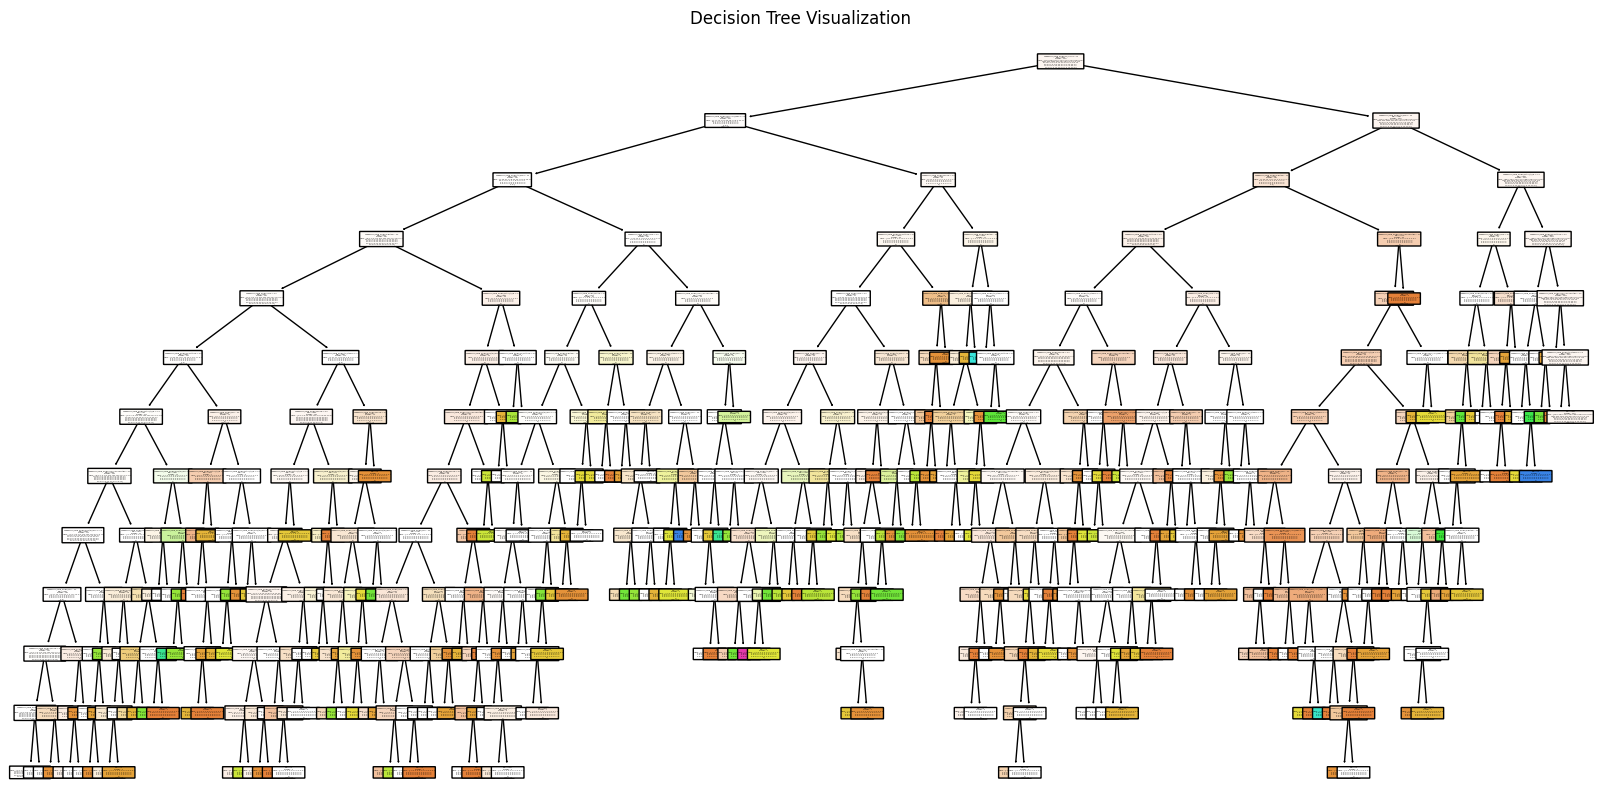

In [26]:
import matplotlib.pyplot as plt
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    clf, 
    feature_names=to_examine, 
    class_names=clf.classes_.astype(str), 
    filled=True, 
    rounded=True
)
plt.title("Decision Tree Visualization")
plt.show()

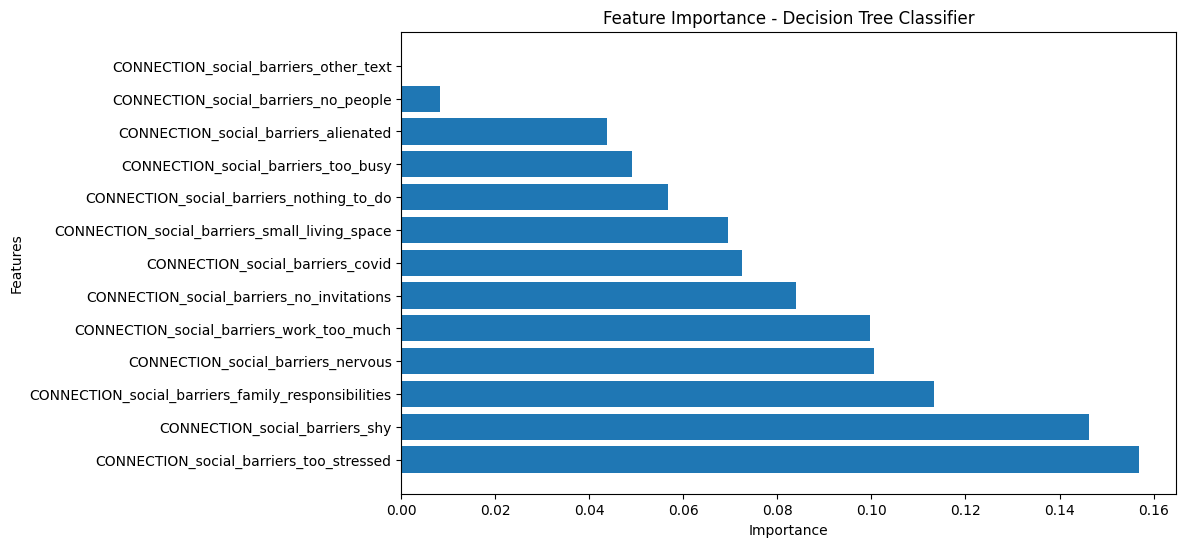

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Get the feature importances from the trained decision tree model
importances = clf.feature_importances_

# Get the feature names
features = X.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Decision Tree Classifier")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


Accuracy: 0.17436380772855797
Confusion Matrix:
 [[179   4   2 ...   0   0   0]
 [144   4   0 ...   0   0   0]
 [132   9   2 ...   0   0   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.18      0.94      0.31       191
         1.0       0.12      0.03      0.04       157
         2.0       0.22      0.01      0.03       149
         3.0       0.00      0.00      0.00       102
         4.0       0.00      0.00      0.00        95
         5.0       0.00      0.00      0.00        74
         6.0       0.00      0.00      0.00        55
         7.0       0.00      0.00      0.00        28
         8.0       0.00      0.00      0.00        30
         9.0       0.00      0.00      0.00        10
        10.0       0.00      0.00      0.00        45
        11.0       0.00      0.00      0.00        10
        12.0       0.00      0.0

C:\Users\Cayden Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Cayden Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Cayden Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\met

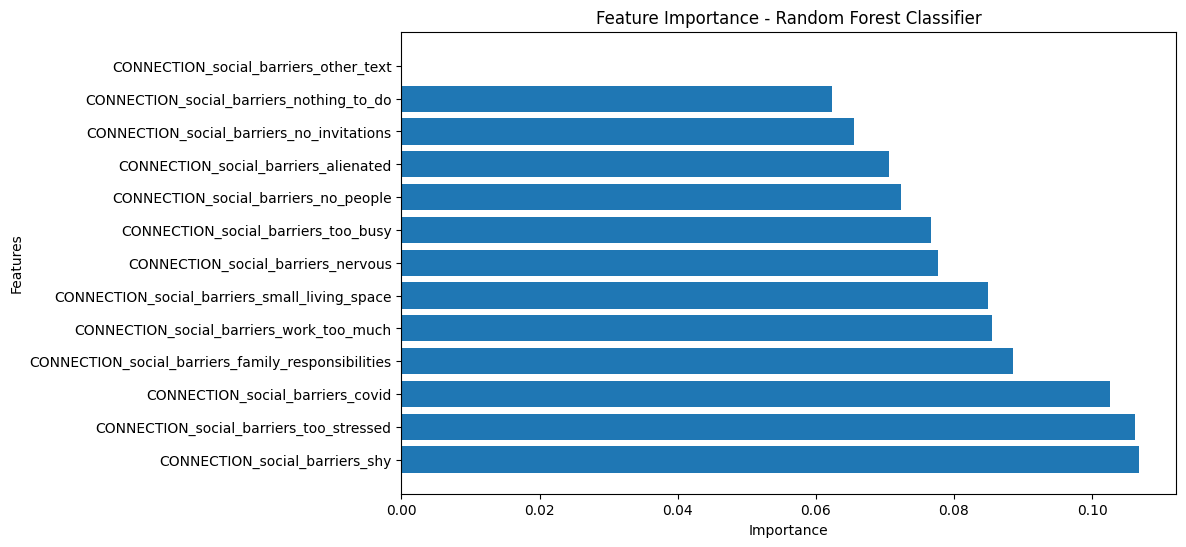

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
clf_rf = RandomForestClassifier(random_state=42)

# Train the model
clf_rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = clf_rf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Plot the feature importances
importances_rf = clf_rf.feature_importances_

# Get the feature names
features_rf = X.columns

# Sort the feature importances in descending order
indices_rf = np.argsort(importances_rf)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forest Classifier")
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], align="center")
plt.yticks(range(len(indices_rf)), [features_rf[i] for i in indices_rf])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


In [29]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Encode categorical variables
def encode_variable(column):
    return column.map({"Not Selected": 0}).fillna(1).astype(int)

# Apply encoding to the variables in to_examine
encoded_data = data[to_examine].apply(encode_variable)

# Add the target variable
encoded_data['CONNECTION_social_time_friends_p7d'] = data['CONNECTION_social_time_friends_p7d']

# Drop rows with missing target variable
encoded_data = encoded_data.dropna(subset=['CONNECTION_social_time_friends_p7d'])

# Features and target variable
X = encoded_data[to_examine]
y = encoded_data['CONNECTION_social_time_friends_p7d']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant term to the predictors for the intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the OLS regression model
ols_model = sm.OLS(y_train, X_train_const).fit()

# Print the summary of the regression model
print(ols_model.summary())

# Predict on the test set
y_pred = ols_model.predict(X_test_const)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")


                                    OLS Regression Results                                    
Dep. Variable:     CONNECTION_social_time_friends_p7d   R-squared:                       0.007
Model:                                            OLS   Adj. R-squared:                  0.004
Method:                                 Least Squares   F-statistic:                     2.401
Date:                                Tue, 26 Nov 2024   Prob (F-statistic):            0.00429
Time:                                        14:12:58   Log-Likelihood:                -14900.
No. Observations:                                4241   AIC:                         2.983e+04
Df Residuals:                                    4228   BIC:                         2.991e+04
Df Model:                                          12                                         
Covariance Type:                            nonrobust                                         
                                                  

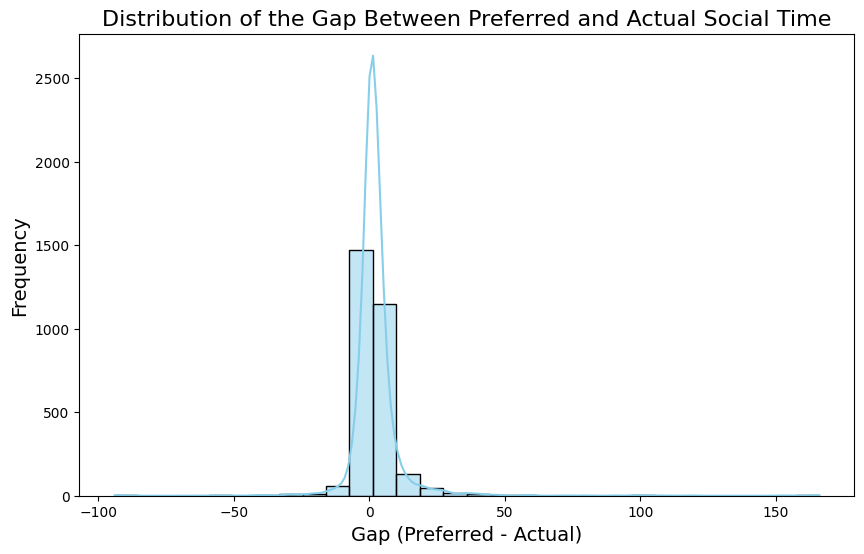

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the gap
data['gap'] = data['CONNECTION_preference_time_friends'] - data['CONNECTION_social_time_friends_p7d']

# Drop rows with missing gap values
gap_data = data['gap'].dropna()

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(gap_data, kde=True, bins=30, color="skyblue", edgecolor="black")

# Add labels and title
plt.title("Distribution of the Gap Between Preferred and Actual Social Time", fontsize=16)
plt.xlabel("Gap (Preferred - Actual)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Show the plot
plt.show()


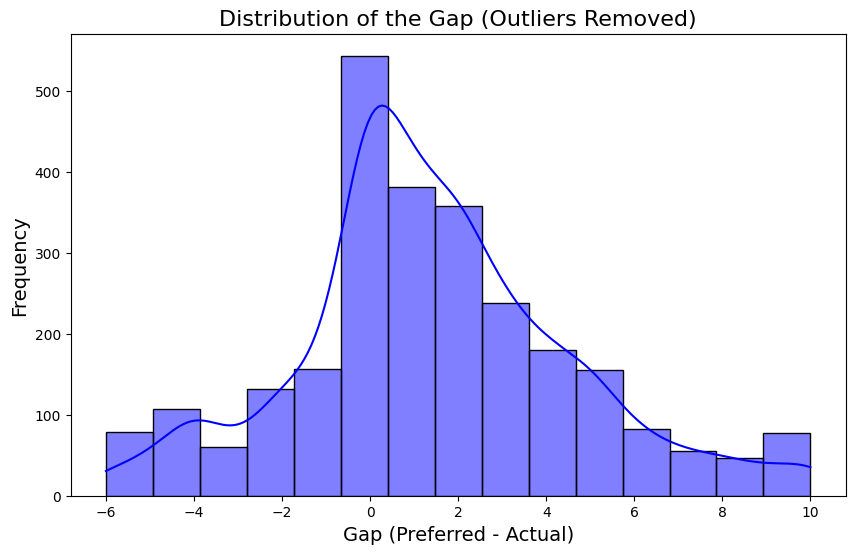

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Copy the data to preserve the original
filtered_data = data.copy()

# Calculate the gap
filtered_data['gap'] = filtered_data['CONNECTION_preference_time_friends'] - filtered_data['CONNECTION_social_time_friends_p7d']

# Drop rows with missing gap values
gap_data = filtered_data['gap'].dropna()

# Calculate the IQR
q1 = gap_data.quantile(0.25)
q3 = gap_data.quantile(0.75)
iqr = q3 - q1

# Define the outlier bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
gap_filtered = gap_data[(gap_data >= lower_bound) & (gap_data <= upper_bound)]

# Plot the histogram of the filtered data
plt.figure(figsize=(10, 6))
sns.histplot(gap_filtered, kde=True, bins=15, color="blue", edgecolor="black")

# Add labels and title
plt.title("Distribution of the Gap (Outliers Removed)", fontsize=16)
plt.xlabel("Gap (Preferred - Actual)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Show the plot
plt.show()


In [32]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Encode categorical variables
def encode_variable(column):
    return column.map({"Not Selected": 0}).fillna(1).astype(int)

# Apply encoding to the variables in to_examine
encoded_data = data[to_examine].apply(encode_variable)

# Add the target variables
encoded_data['CONNECTION_preference_time_friends'] = data['CONNECTION_preference_time_friends']
encoded_data['CONNECTION_social_time_friends_p7d'] = data['CONNECTION_social_time_friends_p7d']
encoded_data['CONNECTION_social_num_close_friends'] = data['CONNECTION_social_num_close_friends']

# Calculate the gap
encoded_data['gap'] = (
    encoded_data['CONNECTION_preference_time_friends'] - encoded_data['CONNECTION_social_time_friends_p7d']
)

# Drop rows with missing values
encoded_data = encoded_data.dropna(subset=['gap'])

# Train-test split
train_data, test_data = train_test_split(encoded_data, test_size=0.2, random_state=42)

# Construct the formula for the regression model
formula = "gap ~ " + " + ".join(to_examine)

# Fit the OLS regression model using smf
ols_model = smf.ols(formula=formula, data=train_data).fit()

# Print the summary of the regression model
print(ols_model.summary())

# Predict on the test set
y_pred = ols_model.predict(test_data)

# Evaluate the model
mse = mean_squared_error(test_data['gap'], y_pred)
r2 = r2_score(test_data['gap'], y_pred)

print(f"\nMean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")


                            OLS Regression Results                            
Dep. Variable:                    gap   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7424
Date:                Tue, 26 Nov 2024   Prob (F-statistic):              0.711
Time:                        14:12:59   Log-Likelihood:                -8891.3
No. Observations:                2341   AIC:                         1.781e+04
Df Residuals:                    2328   BIC:                         1.788e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

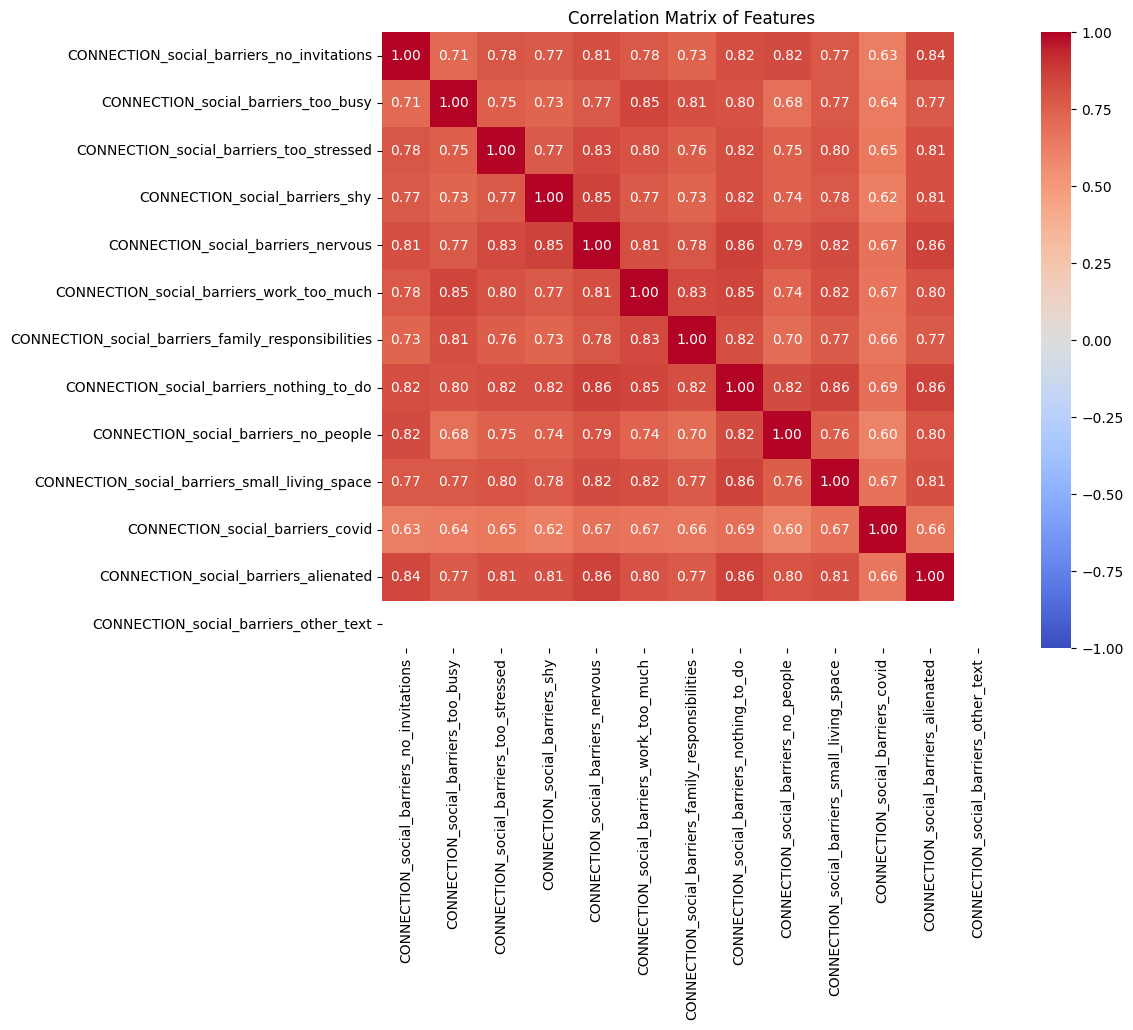

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = encoded_data[to_examine].corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Features")
plt.show()


In [ ]:
import statsmodels.formula.api as smf

# Loop through each column in to_examine
for var in to_examine:
    # Create a formula for the OLS model
    formula = f"gap ~ {var}"
    
    # Fit the OLS model using smf.ols
    ols_model = smf.ols(formula=formula, data=encoded_data).fit()
    
    # Print the summary for each model
    print(f"OLS Model for {var}:")
    print(ols_model.summary())
    print("\n" + "-"*80 + "\n")


OLS Model for CONNECTION_social_barriers_no_invitations:
                            OLS Regression Results                            
Dep. Variable:                    gap   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.299
Date:                Tue, 26 Nov 2024   Prob (F-statistic):              0.254
Time:                        14:12:59   Log-Likelihood:                -10956.
No. Observations:                2927   AIC:                         2.192e+04
Df Residuals:                    2925   BIC:                         2.193e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

In [42]:
# Initialize an empty list to store significant variables
significant_variables = []

# Loop through each column in to_examine
for var in to_examine:
    # Create a formula for the OLS model
    formula = f"CONNECTION_social_num_close_friends ~ {var}"
    
    # Fit the OLS model using smf.ols
    ols_model = smf.ols(formula=formula, data=encoded_data).fit()
    
    # Extract p-values for the model
    p_values = ols_model.pvalues
    if all(p_values < 0.05):
        significant_variables.append(var)
        print(ols_model.summary())
    
    # Check if both the variable and intercept have p-values less than 0.05
    # print(ols_model.summary())


# Print the list of significant variables
print("Significant variables (p-values < 0.05 for both intercept and variable):")
print(significant_variables)

                                     OLS Regression Results                                    
Dep. Variable:     CONNECTION_social_num_close_friends   R-squared:                       0.007
Model:                                             OLS   Adj. R-squared:                  0.006
Method:                                  Least Squares   F-statistic:                     16.50
Date:                                 Tue, 26 Nov 2024   Prob (F-statistic):           5.03e-05
Time:                                         14:17:22   Log-Likelihood:                -6593.1
No. Observations:                                 2490   AIC:                         1.319e+04
Df Residuals:                                     2488   BIC:                         1.320e+04
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
                                        

In [46]:
import statsmodels.formula.api as smf

# Create a formula for the OLS model
formula = f"CONNECTION_social_num_close_friends ~ " + " * ".join(significant_variables)

# Fit the OLS model using smf.ols
ols_model = smf.ols(formula=formula, data=encoded_data).fit()

# Print the summary of the model
print(ols_model.summary())

# Get the p-values
pvalues = ols_model.pvalues

# Filter p-values that are less than 0.05
significant_interactions = pvalues[pvalues < 0.05]

# Get the names of the significant interactions (including main effects and interactions)
significant_interactions_names = significant_interactions.index.tolist()

# Print the significant interactions
print("Significant interactions (p < 0.05):")
print(significant_interactions_names)


                                     OLS Regression Results                                    
Dep. Variable:     CONNECTION_social_num_close_friends   R-squared:                       0.054
Model:                                             OLS   Adj. R-squared:                  0.031
Method:                                  Least Squares   F-statistic:                     2.340
Date:                                 Tue, 26 Nov 2024   Prob (F-statistic):           5.36e-08
Time:                                         14:29:49   Log-Likelihood:                -6532.6
No. Observations:                                 2490   AIC:                         1.319e+04
Df Residuals:                                     2430   BIC:                         1.353e+04
Df Model:                                           59                                         
Covariance Type:                             nonrobust                                         
                                        

In [49]:
import statsmodels.formula.api as smf

# Create a formula for the OLS model
formula = f"CONNECTION_social_num_close_friends ~ " + " + ".join(significant_interactions_names[1:])

# Fit the OLS model using smf.ols
ols_model = smf.ols(formula=formula, data=encoded_data).fit()

# Print the summary of the model
print(ols_model.summary())

                                     OLS Regression Results                                    
Dep. Variable:     CONNECTION_social_num_close_friends   R-squared:                       0.029
Model:                                             OLS   Adj. R-squared:                  0.029
Method:                                  Least Squares   F-statistic:                     37.55
Date:                                 Tue, 26 Nov 2024   Prob (F-statistic):           8.62e-17
Time:                                         15:32:42   Log-Likelihood:                -6564.3
No. Observations:                                 2490   AIC:                         1.313e+04
Df Residuals:                                     2487   BIC:                         1.315e+04
Df Model:                                            2                                         
Covariance Type:                             nonrobust                                         
                                        